## Correlation Analysis
Analyzing the correlation between current state-of-the-art automated metrics and human ratings obtained in the user labeling study.

In [50]:
#!pip install https://github.com/Lightning-AI/torchmetrics/archive/master.zip -q

In [1]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.multitest import multipletests

Load dataframes:
- Human rating
- GPT rating
- Auto scores

In [13]:
# read dfs
human = pd.read_csv(
    "/home/jovyan/BA/Github/thesis-edit-evaluation/labeling/analysis/annotations_mean_3.csv"
)
scores = pd.read_csv("./auto_scores.csv", sep=",").drop(columns=["Unnamed: 0"])

# rename for more consistency
scores = scores.rename(columns={"img_id": "id", "turn_index": "turn"})

# drop irrelevant columns
scores = scores.drop(columns=["source_img", "instruction", "target_img", "mask_img"])
human = human.drop(columns=["_id"])

# reduce to only matches
scores = scores[
    scores.set_index(["id", "turn"]).index.isin(human.set_index(["id", "turn"]).index)
]

In [14]:
human.head(2)

,alignment,quality,consistency,overall,id,turn
0,7.0,8.667,9.000,7.333,142585,1
1,10.0,9.333,9.667,9.667,392687,1


In [15]:
scores.head(2)

,id,turn,clip_score_1,clip_score_2,clip_score_3,lpips_score_1,lpips_score_2,lpips_score_3,lpips_score_4,ssim_score_1,...,psnr_score_3,psnr_score_4,mae_score_1,mae_score_2,mae_score_3,mae_score_4,mse_score_1,mse_score_2,mse_score_3,mse_score_4
0,360871,1,19.634079,19.858503,19.867887,0.691669,0.684465,0.091000,0.100988,0.043516,...,26.308207,26.334354,0.416237,0.411051,0.011799,0.011645,0.208765,0.207070,0.002340,0.002326
1,360871,2,21.497185,21.504286,21.506306,0.682928,0.676702,0.026594,0.017589,0.058028,...,30.250170,27.833601,0.412013,0.402674,0.003158,0.003152,0.205435,0.200275,0.000944,0.000943


## Check for Correlations

In [16]:
def get_correlation_df(df1, df2):
    merged_df = pd.merge(df1, df2, on=["turn", "id"], suffixes=("_df1", "_df2"))

    correlation_results = []

    for df1_col in df1.columns:
        if df1_col in ["turn", "id"]:
            continue

        for df2_col in df2.columns:
            if df2_col in ["turn", "id"]:
                continue

            corr, p_value = stats.spearmanr(merged_df[df1_col], merged_df[df2_col])
            correlation_results.append(
                {
                    "df1": df1_col,
                    "df2": df2_col,
                    "spearman_corr": corr,
                    "p_value": p_value,
                }
            )

    correlation_results_df = pd.DataFrame(correlation_results)
    return correlation_results_df

In [36]:
def show_matrix(df1, df2, text_to_show, save_path):
    merged_df = pd.merge(df1, df2, on=["id", "turn"])
    merged_df = merged_df.drop(["id", "turn"], axis=1)

    compare_columns = [
        col
        for col in merged_df.columns
        if col not in ["alignment", "quality", "consistency", "overall"]
    ]
    target_columns = ["alignment", "quality", "consistency", "overall"]

    correlation_matrix = pd.DataFrame(
        index=compare_columns, columns=target_columns, dtype=float
    )
    significance_matrix = pd.DataFrame(
        index=compare_columns, columns=target_columns, dtype=object
    )

    for df1_col in compare_columns:
        for df2_col in target_columns:
            corr, p_value = stats.spearmanr(merged_df[df1_col], merged_df[df2_col])

            # save spearman correlation coefficient
            correlation_matrix.loc[df1_col, df2_col] = corr

            # compute level of significance
            if p_value < 0.001:
                significance_matrix.loc[df1_col, df2_col] = f"{corr:.2f}***"
            elif p_value < 0.01:
                significance_matrix.loc[df1_col, df2_col] = f"{corr:.2f}**"
            elif p_value < 0.05:
                significance_matrix.loc[df1_col, df2_col] = f"{corr:.2f}*"
            else:
                significance_matrix.loc[df1_col, df2_col] = f"{corr:.2f}"

    # Plot
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        correlation_matrix,
        annot=significance_matrix.values,
        fmt="",
        cmap="coolwarm",
        linewidths=0.5,
        annot_kws={"size": 12},
    )

    plt.title(text_to_show, fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

### Auto Scores & Human
Compute Spearman correlation between automated scores and human annotations. Spearman, since ratings are ordinal data.

In [18]:
correlation_df = get_correlation_df(scores, human)
# correlation_df.to_csv("auto_scores.csv")

In [19]:
correlation_df_sorted = correlation_df.sort_values(by="p_value")
lowest_p_values = correlation_df_sorted.head(8)
print(lowest_p_values)

              df1          df2  spearman_corr   p_value
14  lpips_score_1  consistency       0.143535  0.001730
18  lpips_score_2  consistency       0.137459  0.002708
13  lpips_score_1      quality       0.129102  0.004876
0    clip_score_1    alignment      -0.124375  0.006704
54   psnr_score_3  consistency       0.123463  0.007120
86    mse_score_3  consistency      -0.123463  0.007120
90    mse_score_4  consistency      -0.123187  0.007250
37   ssim_score_3      quality       0.120720  0.008515


Compute for all different processing options to get a first overview of results.

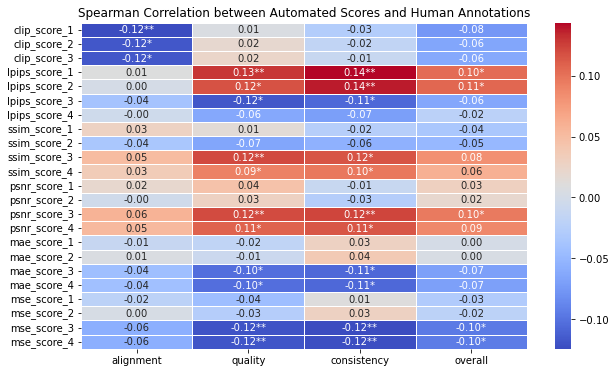

In [20]:
show_matrix(
    scores,
    human,
    "Spearman Correlation between Automated Scores and Human Annotations",
    save_path="correlation_auto_human.png",
)

In [21]:
scores_reduced = scores.drop(
    [
        "clip_score_1",
        "clip_score_3",
        "lpips_score_1",
        "lpips_score_2",
        "lpips_score_4",
        "ssim_score_1",
        "ssim_score_2",
        "ssim_score_4",
        "psnr_score_1",
        "psnr_score_2",
        "psnr_score_4",
        "mae_score_1",
        "mae_score_2",
        "mae_score_4",
        "mse_score_1",
        "mse_score_2",
        "mse_score_4",
    ],
    axis=1,
)

Since results are very similar among options, reduce the scores to option 3.

In [31]:
scores_reduced = scores_reduced.rename(
    columns=lambda x: x.split("_")[0].upper() if "score" in x else x
)

In [38]:
correlation_df_reduced = get_correlation_df(scores_reduced, human)
correlation_df_reduced_sorted = correlation_df_reduced.sort_values(by="p_value")
lowest_p_values_reduced = correlation_df_reduced_sorted.head(15)
print(lowest_p_values_reduced)

      df1          df2  spearman_corr   p_value
14   psnr  consistency       0.123463  0.007120
22    mse  consistency      -0.123463  0.007120
9    ssim      quality       0.120720  0.008515
21    mse      quality      -0.119540  0.009186
13   psnr      quality       0.119540  0.009186
5   lpips      quality      -0.117989  0.010140
0    clip    alignment      -0.117077  0.010742
10   ssim  consistency       0.116122  0.011405
18    mae  consistency      -0.107503  0.019226
6   lpips  consistency      -0.106966  0.019841
17    mae      quality      -0.102596  0.025505
15   psnr      overall       0.095797  0.037075
23    mse      overall      -0.095797  0.037075
11   ssim      overall       0.082169  0.073896
19    mae      overall      -0.069796  0.129164


Apply Benjamini-Hochberg correction, accounting for multiple tests.

In [52]:
p_values = correlation_df_reduced["p_value"].tolist()

# `rejected` is a boolean array: True = significant after FDR
# `pvals_corrected` gives the adjusted p-values
rejected, pvals_corrected, _, _ = multipletests(p_values, method="fdr_bh")

correlation_df_reduced["p_value_fdr"] = pvals_corrected
correlation_df_reduced["significant_fdr"] = rejected

In [68]:
correlation_df_reduced.head(2)

,df1,df2,spearman_corr,p_value,p_value_fdr,significant_fdr
0,clip,alignment,-0.117077,0.010742,0.034214,True
1,clip,quality,0.019007,0.679780,0.709335,False


Adjusted function from above, taking the pre-computed dataframe.

In [63]:
def show_precomputed_matrix(precomputed_df, text_to_show, save_path=None):
    compare_columns = precomputed_df["df1"].unique()
    target_columns = precomputed_df["df2"].unique()

    correlation_matrix = pd.DataFrame(
        index=compare_columns, columns=target_columns, dtype=float
    )
    significance_matrix = pd.DataFrame(
        index=compare_columns, columns=target_columns, dtype=object
    )

    for _, row in precomputed_df.iterrows():
        df1_col = row["df1"]
        df2_col = row["df2"]
        corr = row["spearman_corr"]
        p_value = row["p_value_fdr"]

        correlation_matrix.loc[df1_col, df2_col] = corr

        if p_value < 0.001:
            significance_matrix.loc[df1_col, df2_col] = f"{corr:.2f}***"
        elif p_value < 0.01:
            significance_matrix.loc[df1_col, df2_col] = f"{corr:.2f}**"
        elif p_value < 0.05:
            significance_matrix.loc[df1_col, df2_col] = f"{corr:.2f}*"
        else:
            significance_matrix.loc[df1_col, df2_col] = f"{corr:.2f}"

    # Plot
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        correlation_matrix,
        annot=significance_matrix.values,
        fmt="",
        cmap="coolwarm",
        linewidths=0.5,
        annot_kws={"size": 12},
    )

    plt.title(text_to_show, fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

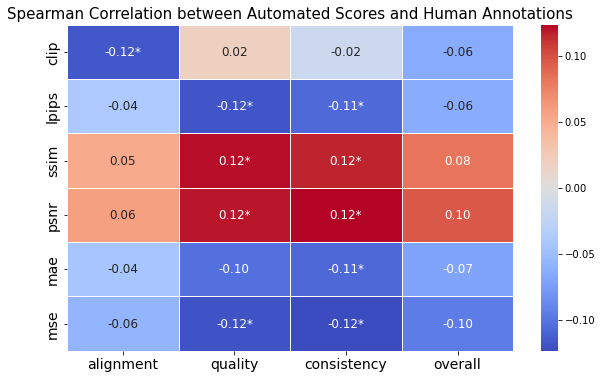

In [66]:
show_precomputed_matrix(
    correlation_df_reduced,
    "Spearman Correlation between Automated Scores and Human Annotations",
    save_path="correlation_auto_human_reduced.png",
)

# Other

### GPT & Human 
Compute correlation between GPT judgements & human annotations.

In [ ]:
correlation_df = get_correlation_df(gpt, human)
print(correlation_df)

In [ ]:
show_matrix(gpt, human, "Correlation between GPT and human")

- The correlation is stronger with multi-value ratings compared to binary ratings
- The highest correlation is observed between GPT scores and the **overall** human score, rather than with the detailed categories (alignment, aesthetics, consistency)
- GPT's alignment score correlates strongest with all human ratings

### Auto Scores & GPT
- Only for estimation.

In [30]:
correlation_df = get_correlation_df(scores, gpt)

correlation_df_sorted = correlation_df.sort_values(by="p_value")
lowest_p_values = correlatyion_df_sorted.head(8)
print(lowest_p_values)

                  df1             df2  spearman_corr   p_value
79  dream_sim_score_3         overall       0.143447  0.213279
77  dream_sim_score_3  visual_quality       0.143418  0.213371
76  dream_sim_score_3       alignment       0.129945  0.259999
83      lpips_score_4         overall       0.126507  0.272927
87       ssim_score_4         overall      -0.114945  0.319520
58        mse_score_1     consistency      -0.104383  0.366291
34       psnr_score_1     consistency       0.104383  0.366291
82      lpips_score_4     consistency       0.103127  0.372117


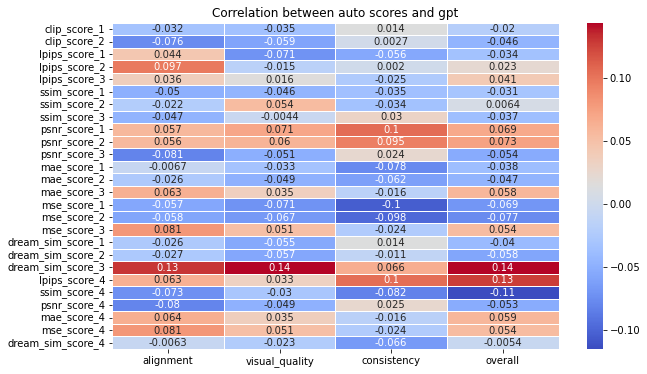

In [31]:
show_matrix(
    auto_scores.drop(columns=["human_rating_binary"]),
    gpt_scores.drop(columns=["model"]),
    "Correlation between auto scores and gpt",
)